In [1]:
import pandas as pd #загружаем библиотеку

In [2]:
data = pd.read_csv('query_result.csv') #читаем данные

In [3]:
data.head(5)

,flight_id,flight_no,departure_airport,arrival_airport,actual_departure,actual_arrival,flight_duration,model,sum_tickets_sold
0,136661,PG0480,AAQ,EGO,2017-01-01T09:27:00,2017-01-01T10:17:00,50.0,Sukhoi Superjet-100,759000.0
1,136420,PG0252,AAQ,SVO,2017-01-01T10:09:00,2017-01-01T11:47:00,98.0,Boeing 737-300,1542000.0
2,136936,PG0480,AAQ,EGO,2017-01-02T09:28:00,2017-01-02T10:18:00,50.0,Sukhoi Superjet-100,632400.0
3,136458,PG0252,AAQ,SVO,2017-01-02T10:07:00,2017-01-02T11:46:00,99.0,Boeing 737-300,1568800.0
4,136546,PG0194,AAQ,NOZ,2017-01-03T06:13:00,2017-01-03T11:15:00,302.0,Boeing 737-300,NaN


In [4]:
data.info() #смотрим, что из себя представляют

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   flight_id          127 non-null    int64  
 1   flight_no          127 non-null    object 
 2   departure_airport  127 non-null    object 
 3   arrival_airport    127 non-null    object 
 4   actual_departure   127 non-null    object 
 5   actual_arrival     127 non-null    object 
 6   flight_duration    127 non-null    float64
 7   model              127 non-null    object 
 8   sum_tickets_sold   118 non-null    float64
dtypes: float64(2), int64(1), object(6)
memory usage: 9.1+ KB


In [5]:
#цена авиатоплива в 2017 году (данные взяты с сайта Федерального агенства воздушного транспорта Росавиации)
#среднее значение 46803 рубля/тонну

In [6]:
data.model.unique()

array(['Sukhoi Superjet-100', 'Boeing 737-300'], dtype=object)

In [7]:
#расход топлива для моделей самолетов взят из документа "О нормах расхода топлива на эксплуатацию самолетов и вертолетов гражданской авиации"
# для Boeing 737-300 составляет 2400 кг/час
# для Sukhoi Superjet-100 1700 кг/час

In [8]:
df = data.copy() #делаем копию, далее работаем с копией, чтоб вернуться к неповторимому оригиналу, если что-то пойдет не по плану

In [9]:
#создаем столбец с расходом топлива (здесь и далее мой любимый прием с прохождением по серии со словарем)

df['fuel_consumption'] = df['model']
fuel_consumption = {'Sukhoi Superjet-100':1.7,
                   'Boeing 737-300':2.4
                   }
df['fuel_consumption'] = df['fuel_consumption'].replace(to_replace = fuel_consumption)

In [10]:
#создаем столбец с расходами на полет (формула логически вытекает из проведенных выше действий)
df['flight_expense'] = df.flight_duration/60*df.fuel_consumption*46803

In [11]:
#создаем столбец с прибылью

df['flight_profit'] = df.sum_tickets_sold - df.flight_expense

In [13]:
#города вылета и прилета в отличии от кодов аэропортов были в условиях задания

airports_code = { 'AAQ' : 'Anapa', 
                 'EGO' : 'Belgorod', 
                 'SVO' : 'Moscow', 
                 'NOZ' : 'Novokuznetsk'
                }

df['departure_airport'] = df['departure_airport'].replace(to_replace = airports_code )
df['arrival_airport'] = df['arrival_airport'].replace(to_replace = airports_code )

In [24]:
#приводим к формату даты для последующей работы

df['actual_departure'] = pd.to_datetime(df['actual_departure'])
df['actual_arrival'] = pd.to_datetime(df['actual_arrival'])

In [25]:
#мне покзалось, что дни недели могут оказаться важными

df['day_of_week'] = df['actual_departure'].dt.dayofweek

In [26]:
#приводим дни недели в более понятный формат

day_of_week = { 0 : 'Monday',
              1 : 'Tuesday',
              2 : 'Wednesday',
              3 : 'Tursday',
              4 : 'Friday',
              5 : 'Saturday',
              6 : 'Sunday'
              }
df['day_of_week'] = df['day_of_week'].replace(to_replace = day_of_week)

In [50]:
#есть странные корреляции... но пока не буду об этом думать
df.corr()

,flight_id,flight_duration,sum_tickets_sold,fuel_consumption,flight_expense,flight_profit
flight_id,1.000000,-0.334563,-0.872855,-0.869044,-0.404241,-0.865381
flight_duration,-0.334563,1.000000,0.974231,0.599836,0.996395,0.966493
sum_tickets_sold,-0.872855,0.974231,1.000000,0.976290,0.974770,0.999484
fuel_consumption,-0.869044,0.599836,0.976290,1.000000,0.665535,0.968873
flight_expense,-0.404241,0.996395,0.974770,0.665535,1.000000,0.967100
flight_profit,-0.865381,0.966493,0.999484,0.968873,0.967100,1.000000


<AxesSubplot:xlabel='arrival_airport'>

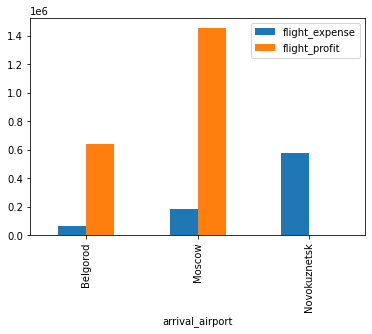

In [49]:
#самое простое: визуализация отношений прибыли к затратам 

df.pivot_table(values = ['flight_profit', 'flight_expense'],
                index = 'arrival_airport',
                aggfunc = 'mean').plot(kind = 'bar')

<AxesSubplot:xlabel='day_of_week'>

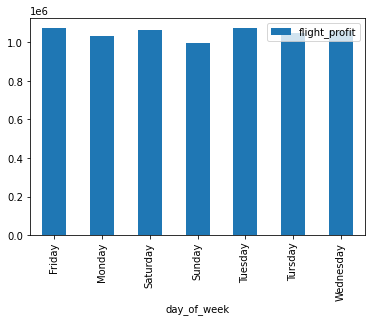

In [35]:
#прибыль по дням недели

df.pivot_table(values = ['flight_profit'],
                index = 'day_of_week',
                aggfunc = 'mean').plot(kind = 'bar')

<AxesSubplot:xlabel='arrival_airport'>

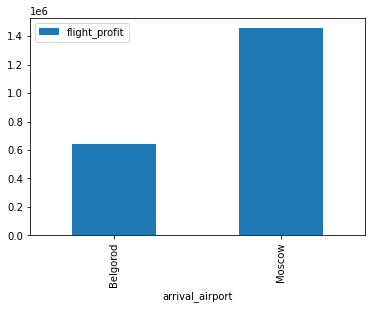

In [36]:
#прибыль по городам

df.pivot_table(values = ['flight_profit'],
                index = 'arrival_airport',
                aggfunc = 'mean').plot(kind = 'bar')

In [40]:
#захотелось графики повеселее...

import seaborn as sns
import warnings; warnings.simplefilter('ignore')

<AxesSubplot:xlabel='arrival_airport', ylabel='flight_profit'>

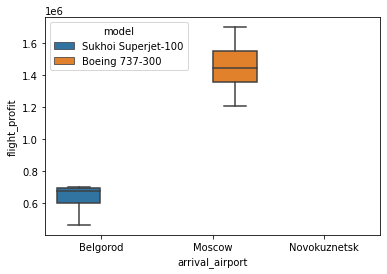

In [46]:
#куда какие самолеты летают и сколько прибыли приносят (в Новокузнецк тоже летают, но там есть вопросы)

sns.boxplot(x = 'arrival_airport', y = 'flight_profit', data = df, hue = 'model')

<AxesSubplot:xlabel='day_of_week', ylabel='flight_profit'>

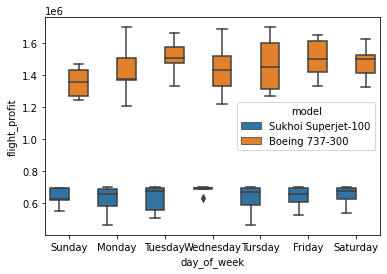

In [47]:
#мы уже поняли какие самолеты куда летают, поэтому можно принять одно за второе и посмотреть, что там по дням недели

sns.boxplot(x = 'day_of_week', y = 'flight_profit', data = df, hue = 'model')

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

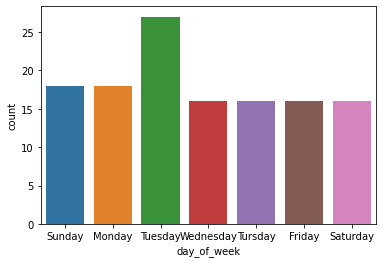

In [44]:
sns.countplot(x = 'day_of_week', data = df)